In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义生成对抗网络（GAN）的生成器
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10, img_size=28, num_channels=1, embed_dim=50):
        super(ConditionalGenerator, self).__init__()
        self.img_size = img_size
        self.num_channels = num_channels
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim

        # 标签嵌入层：将类别标签转换为一个嵌入向量
        self.embedding = nn.Embedding(num_classes, embed_dim)

        # 全连接层，将噪声向量和嵌入向量拼接后，映射到适合反卷积层的起始维度
        # (latent_dim + embed_dim) -> (256 * 7 * 7)
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 128 * (img_size // 4) * (img_size // 4)),
            nn.BatchNorm1d(128 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(True)
        )

        # 反卷积层 (DCGAN 风格)
        self.main = nn.Sequential(
            # 输入特征图尺寸: 256 x 7 x 7
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # -> 128 x 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),  # -> 64 x 28 x 28
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # 最后一层反卷积，输出图像
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, stride=1, padding=1, bias=False),  # -> num_channels x 28 x 28
            nn.Tanh()  # 将像素值缩放到 [-1, 1] 范围，与 MNIST 预处理后的范围一致
        )

    def forward(self, noise, labels):
        # 1. 将标签转换为嵌入向量 (batch_size, embed_dim)
        label_embedding = self.embedding(labels).squeeze(1)
        # 2. 将噪声向量和标签嵌入向量拼接 (batch_size, latent_dim + embed_dim)
        combined_input = torch.cat([noise, label_embedding], dim=1)
        # 3. 通过全连接层将其转换为适合反卷积的形状
        x = self.fc_layer(combined_input)
        # 4. reshape 成特征图 (batch_size, 256, img_size//4, img_size//4)
        x = x.view(x.size(0), 128, self.img_size // 4, self.img_size // 4)
        # 5. 通过反卷积层生成图像
        image = self.main(x)
        return image


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_size=28, num_channels=1, embed_dim=50):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.num_channels = num_channels
        self.embed_dim = embed_dim

        # 标签嵌入层：将类别标签转换为嵌入向量
        # self.embedding = nn.Embedding(num_classes, embed_dim)
        self.embedding = nn.Sequential(
            nn.Embedding(num_classes, embed_dim),
            nn.Linear(embed_dim,784),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # 判别器的主体卷积层
        self.main = nn.Sequential(
            # 输入: (num_channels + 1) x 28 x 28
            nn.Conv2d(num_channels + 1, 32, kernel_size=4, stride=2, padding=1, bias=False),  # -> 64 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),  # -> 128 x 7 x 7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # -> 256 x 3 x 3 (或 4x4, 取决于计算)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.final_conv_to_flat = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=0, bias=False)
        # 现在输出是 (batch_size, 1, 1, 1)

    def forward(self, image, labels):
        # 1. 将标签转换为嵌入向量 (batch_size, embed_dim)
        label_embedding = self.embedding(labels)

        # 2. 将标签嵌入扩展到图像的 HxW 维度，以便与图像拼接
        # 例如，将 (batch_size, embed_dim) 扩展为 (batch_size, 1, img_size, img_size)
        label_map = label_embedding.view(label_embedding.size(0), 1, self.img_size, self.img_size)
        image = image.reshape(image.size(0), self.num_channels, self.img_size, self.img_size)  # 确保图像是 (batch_size, num_channels, img_size, img_size)

        # 3. 将图像和标签嵌入图在通道维度上拼接
        # 输入到判别器的第一层卷积将是 (batch_size, num_channels + 1, img_size, img_size)
        combined_input = torch.cat([image, label_map], dim=1)

        # 4. 通过卷积层提取特征
        features = self.main(combined_input)

        # 5. 通过最终卷积层将空间维度压缩为 1x1，并展平
        output = self.final_conv_to_flat(features)  # (batch_size, 1, 1, 1)
        output = output.view(-1, 1)  # (batch_size, 1)

        return output

开始GAN训练...
Epoch [1/500] D Loss: 1.1915, G Loss: 0.8697
Generating images at epoch 1...


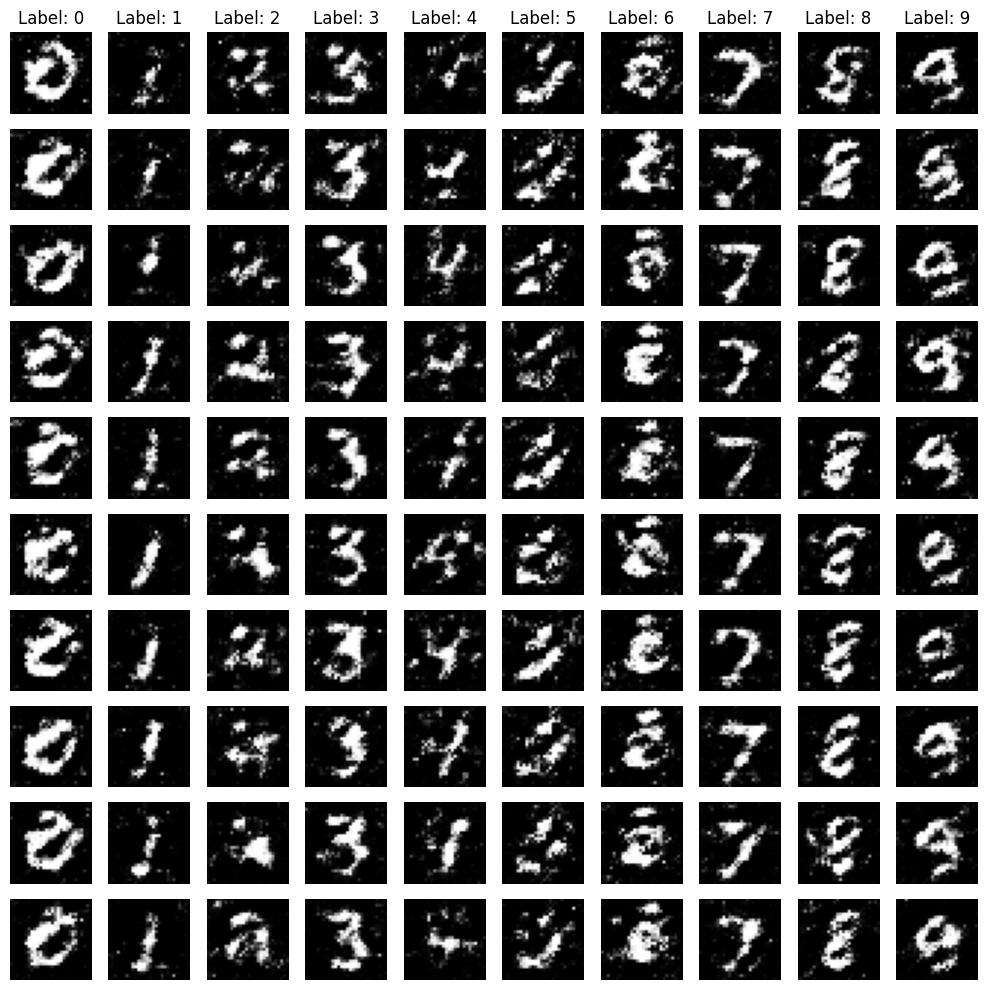

Epoch [2/500] D Loss: 1.1818, G Loss: 0.9366
Epoch [3/500] D Loss: 1.1237, G Loss: 1.0411
Epoch [4/500] D Loss: 1.0346, G Loss: 1.1787
Epoch [5/500] D Loss: 1.0038, G Loss: 1.2729
Epoch [6/500] D Loss: 0.9451, G Loss: 1.3695
Epoch [7/500] D Loss: 0.9030, G Loss: 1.4548
Epoch [8/500] D Loss: 0.9173, G Loss: 1.4496
Epoch [9/500] D Loss: 0.9159, G Loss: 1.4812
Epoch [10/500] D Loss: 0.8781, G Loss: 1.5320
Generating images at epoch 10...


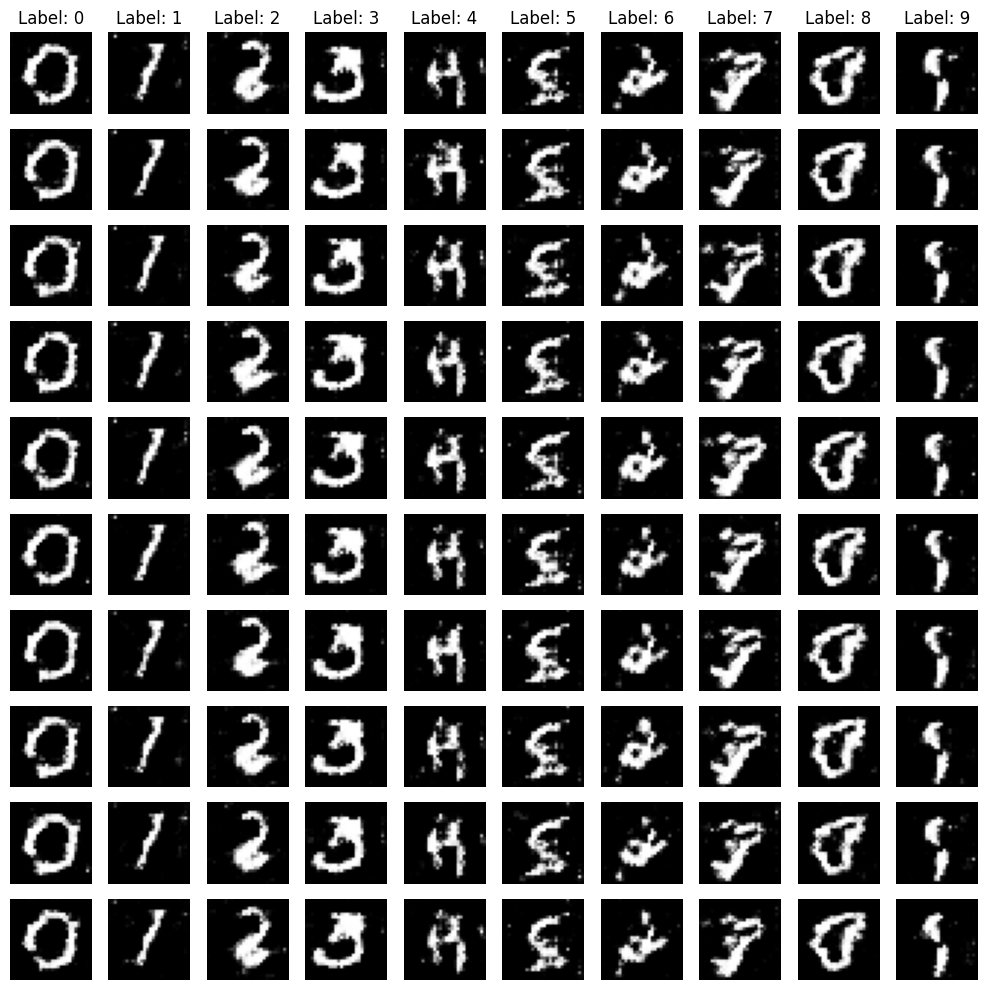

Epoch [11/500] D Loss: 0.8422, G Loss: 1.6045
Epoch [12/500] D Loss: 0.9009, G Loss: 1.5456
Epoch [13/500] D Loss: 0.8337, G Loss: 1.5835
Epoch [14/500] D Loss: 0.8260, G Loss: 1.6369
Epoch [15/500] D Loss: 0.8695, G Loss: 1.6182
Epoch [16/500] D Loss: 0.8357, G Loss: 1.6365
Epoch [17/500] D Loss: 0.8748, G Loss: 1.5442
Epoch [18/500] D Loss: 0.7803, G Loss: 1.7270
Epoch [19/500] D Loss: 0.8512, G Loss: 1.6352
Epoch [20/500] D Loss: 0.7776, G Loss: 1.6885
Generating images at epoch 20...


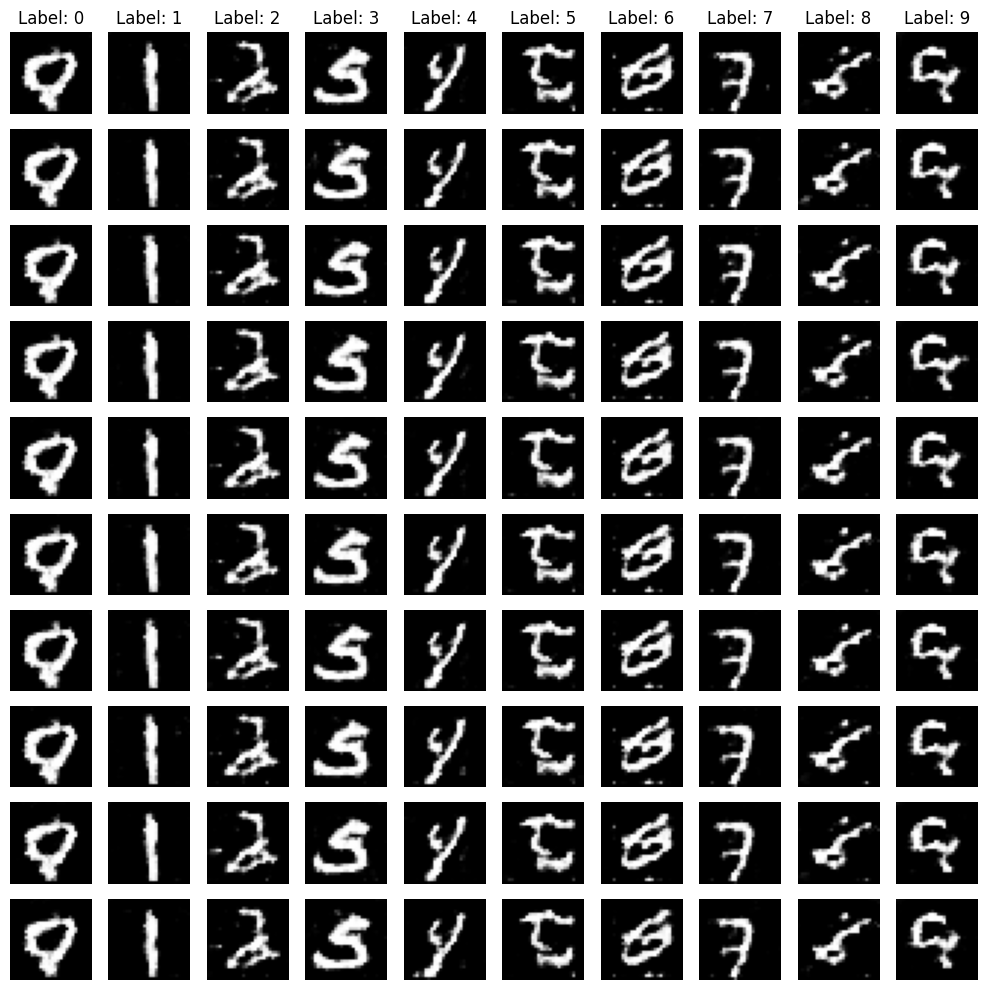

Epoch [21/500] D Loss: 0.8468, G Loss: 1.6717
Epoch [22/500] D Loss: 0.8184, G Loss: 1.7269
Epoch [23/500] D Loss: 0.8077, G Loss: 1.6896
Epoch [24/500] D Loss: 0.8097, G Loss: 1.7040
Epoch [25/500] D Loss: 0.7767, G Loss: 1.7408
Epoch [26/500] D Loss: 0.7950, G Loss: 1.7952
Epoch [27/500] D Loss: 0.7613, G Loss: 1.7512
Epoch [28/500] D Loss: 0.7899, G Loss: 1.7436
Epoch [29/500] D Loss: 0.7732, G Loss: 1.8243
Epoch [30/500] D Loss: 0.7810, G Loss: 1.7811
Generating images at epoch 30...


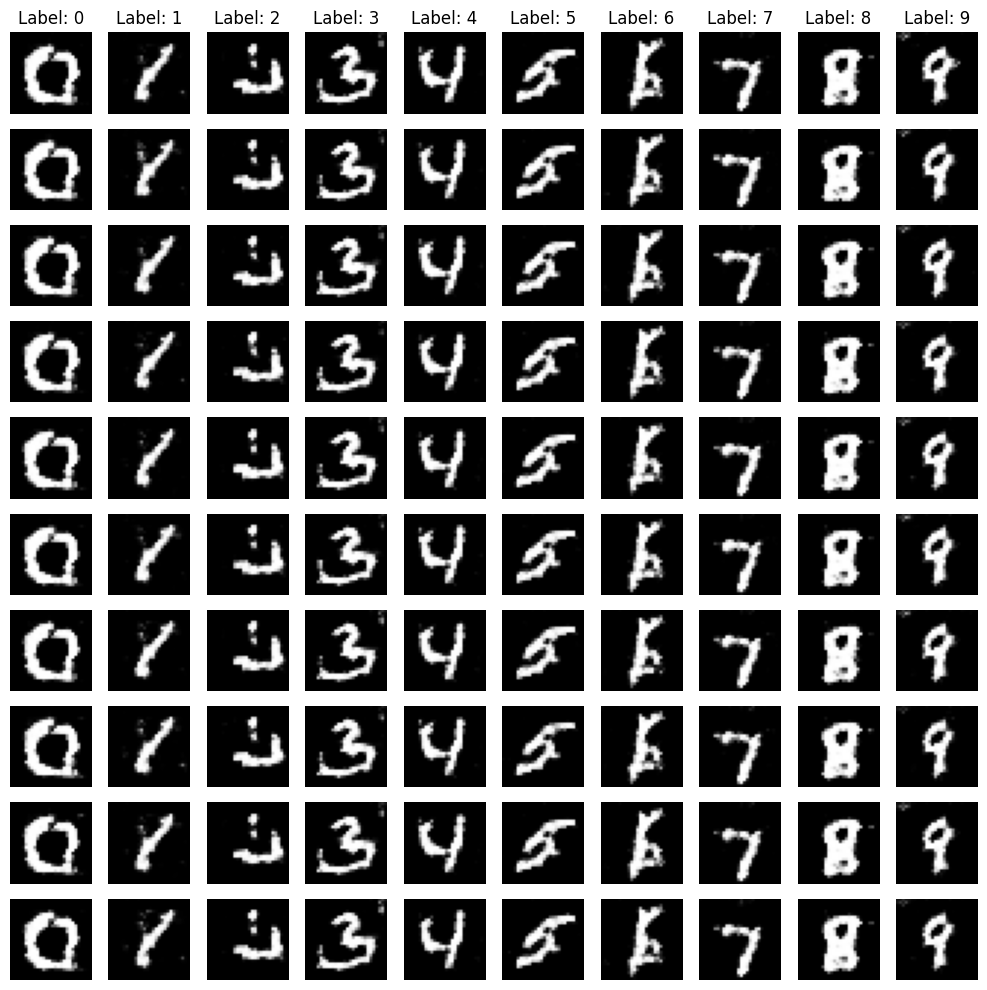

Epoch [31/500] D Loss: 0.7720, G Loss: 1.8118
Epoch [32/500] D Loss: 0.8060, G Loss: 1.7497
Epoch [33/500] D Loss: 0.8729, G Loss: 1.6496
Epoch [34/500] D Loss: 0.8034, G Loss: 1.7005
Epoch [35/500] D Loss: 0.7491, G Loss: 1.8092
Epoch [36/500] D Loss: 0.7378, G Loss: 1.8038
Epoch [37/500] D Loss: 0.7770, G Loss: 1.8170
Epoch [38/500] D Loss: 0.7529, G Loss: 1.7739
Epoch [39/500] D Loss: 0.7895, G Loss: 1.7526
Epoch [40/500] D Loss: 0.8197, G Loss: 1.7887
Generating images at epoch 40...


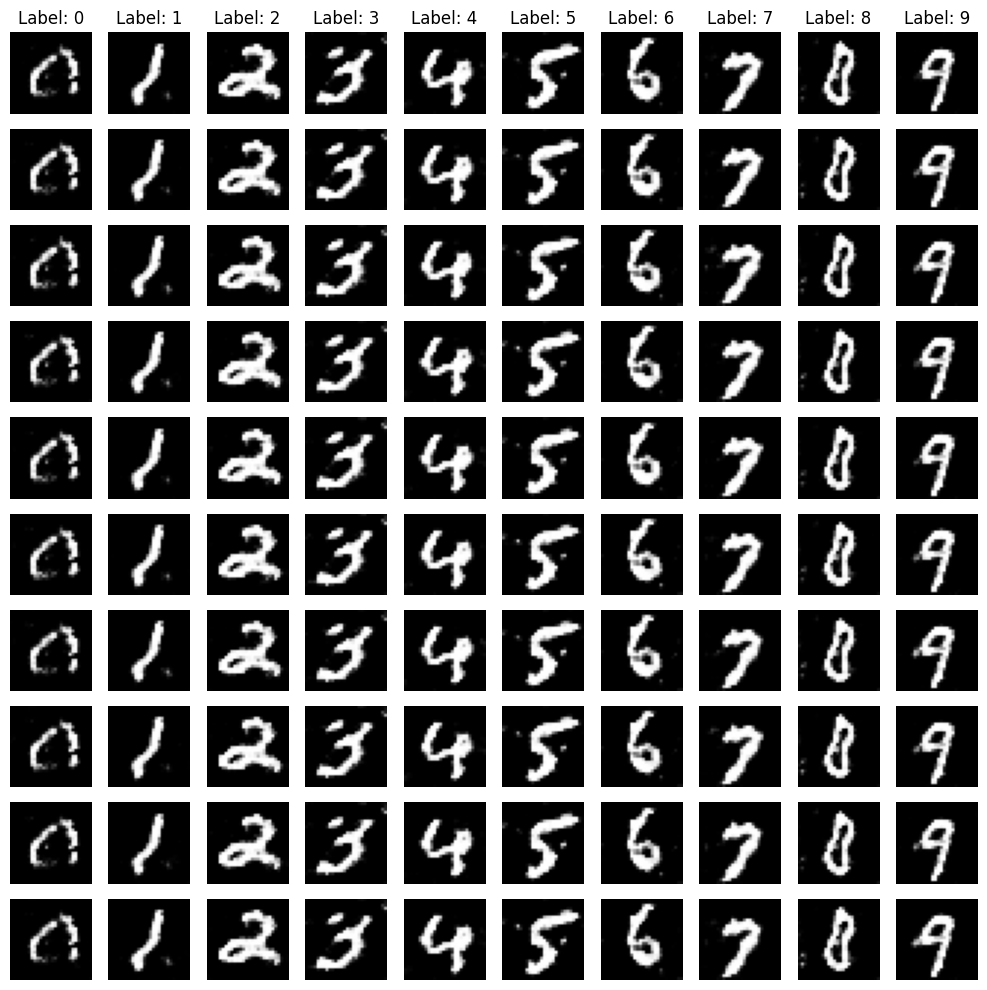

Epoch [41/500] D Loss: 0.7856, G Loss: 1.7666
Epoch [42/500] D Loss: 0.7848, G Loss: 1.8499
Epoch [43/500] D Loss: 0.7771, G Loss: 1.8125
Epoch [44/500] D Loss: 0.7296, G Loss: 1.8901
Epoch [45/500] D Loss: 0.7372, G Loss: 1.8645
Epoch [46/500] D Loss: 0.7611, G Loss: 1.7883
Epoch [47/500] D Loss: 0.7848, G Loss: 1.7928
Epoch [48/500] D Loss: 0.7271, G Loss: 1.9560
Epoch [49/500] D Loss: 0.8014, G Loss: 1.7502
Epoch [50/500] D Loss: 0.7292, G Loss: 1.9610
Generating images at epoch 50...


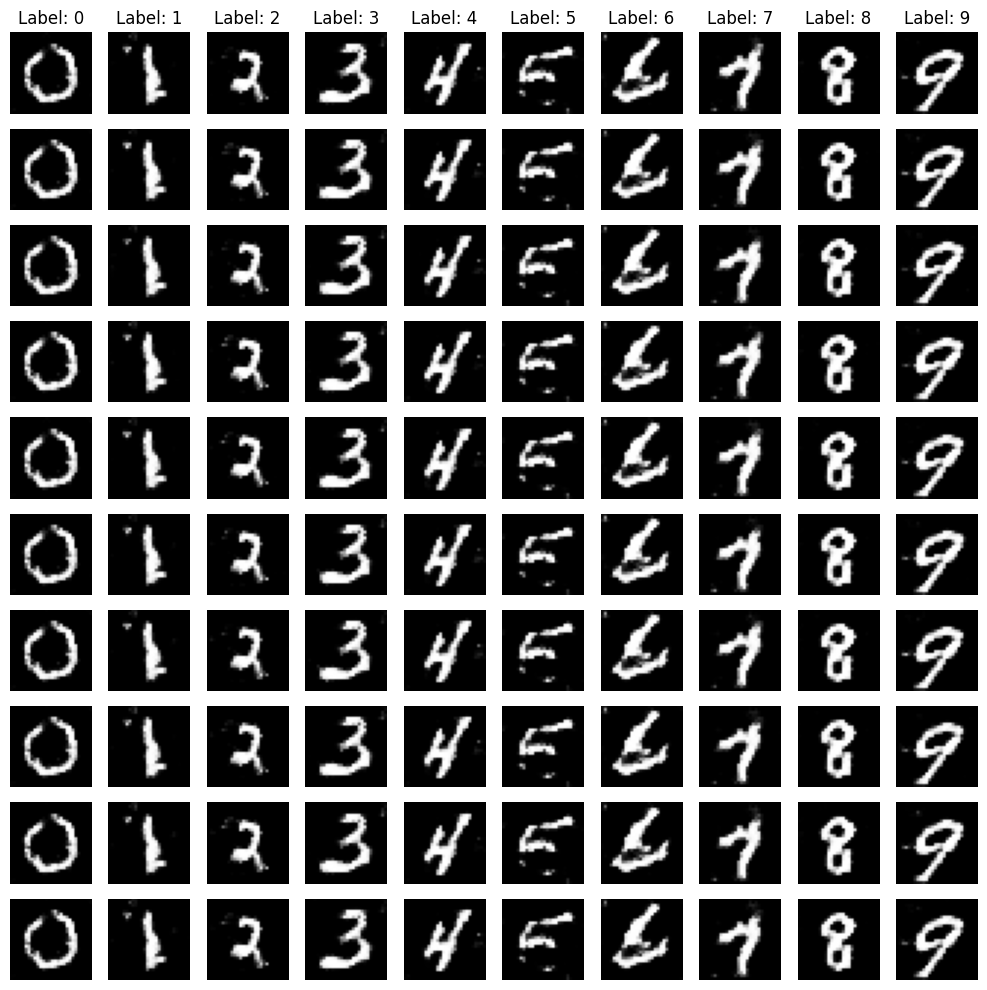

Epoch [51/500] D Loss: 0.7445, G Loss: 1.8344
Epoch [52/500] D Loss: 0.7599, G Loss: 1.9714
Epoch [53/500] D Loss: 0.7279, G Loss: 1.8498
Epoch [54/500] D Loss: 0.7933, G Loss: 1.8260
Epoch [55/500] D Loss: 0.7357, G Loss: 1.8270
Epoch [56/500] D Loss: 0.7371, G Loss: 1.9139
Epoch [57/500] D Loss: 0.7392, G Loss: 2.0141
Epoch [58/500] D Loss: 0.7631, G Loss: 1.8868
Epoch [59/500] D Loss: 0.7522, G Loss: 1.9092
Epoch [60/500] D Loss: 0.7524, G Loss: 1.8370
Generating images at epoch 60...


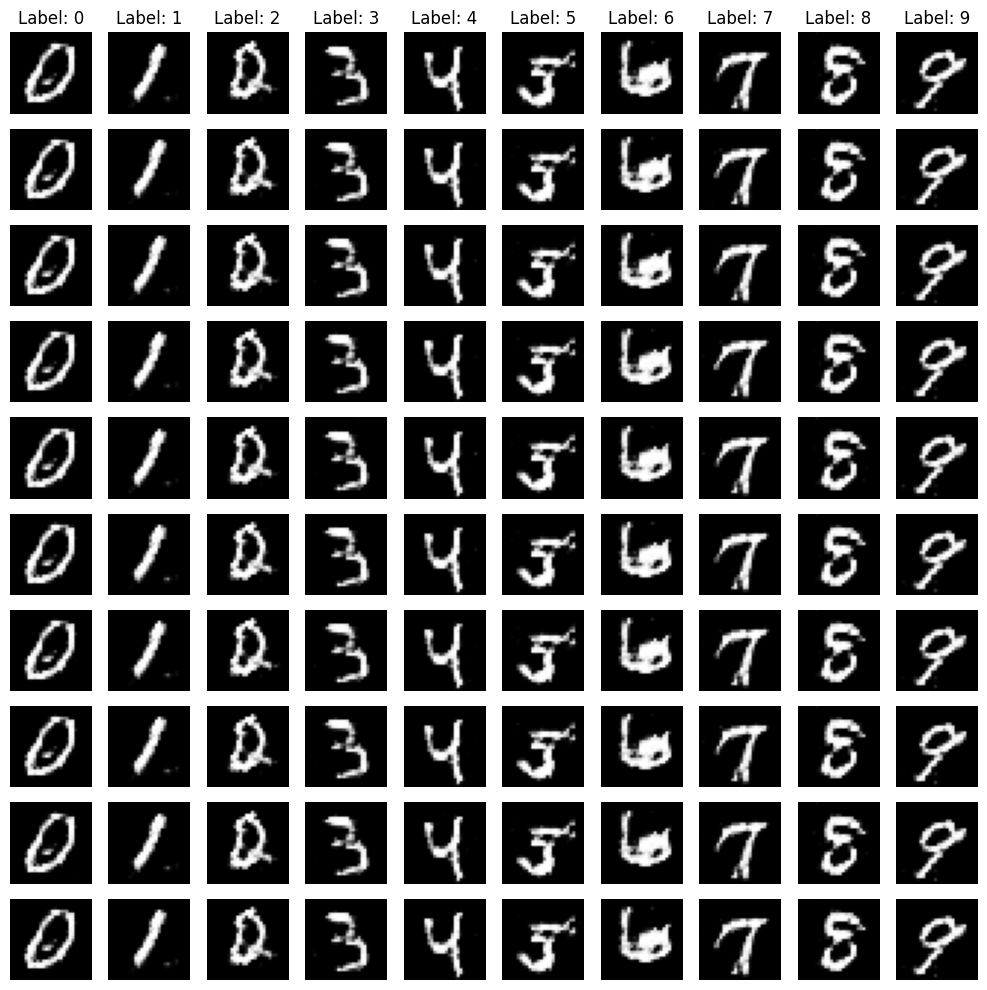

Epoch [61/500] D Loss: 0.7351, G Loss: 1.9043
Epoch [62/500] D Loss: 0.7524, G Loss: 1.9359
Epoch [63/500] D Loss: 0.6984, G Loss: 1.9677
Epoch [64/500] D Loss: 0.7324, G Loss: 1.9255
Epoch [65/500] D Loss: 0.7906, G Loss: 1.9082
Epoch [66/500] D Loss: 0.6958, G Loss: 1.9286
Epoch [67/500] D Loss: 0.6985, G Loss: 2.0090
Epoch [68/500] D Loss: 0.7220, G Loss: 1.9319
Epoch [69/500] D Loss: 0.6838, G Loss: 2.0607
Epoch [70/500] D Loss: 0.7183, G Loss: 2.0029
Generating images at epoch 70...


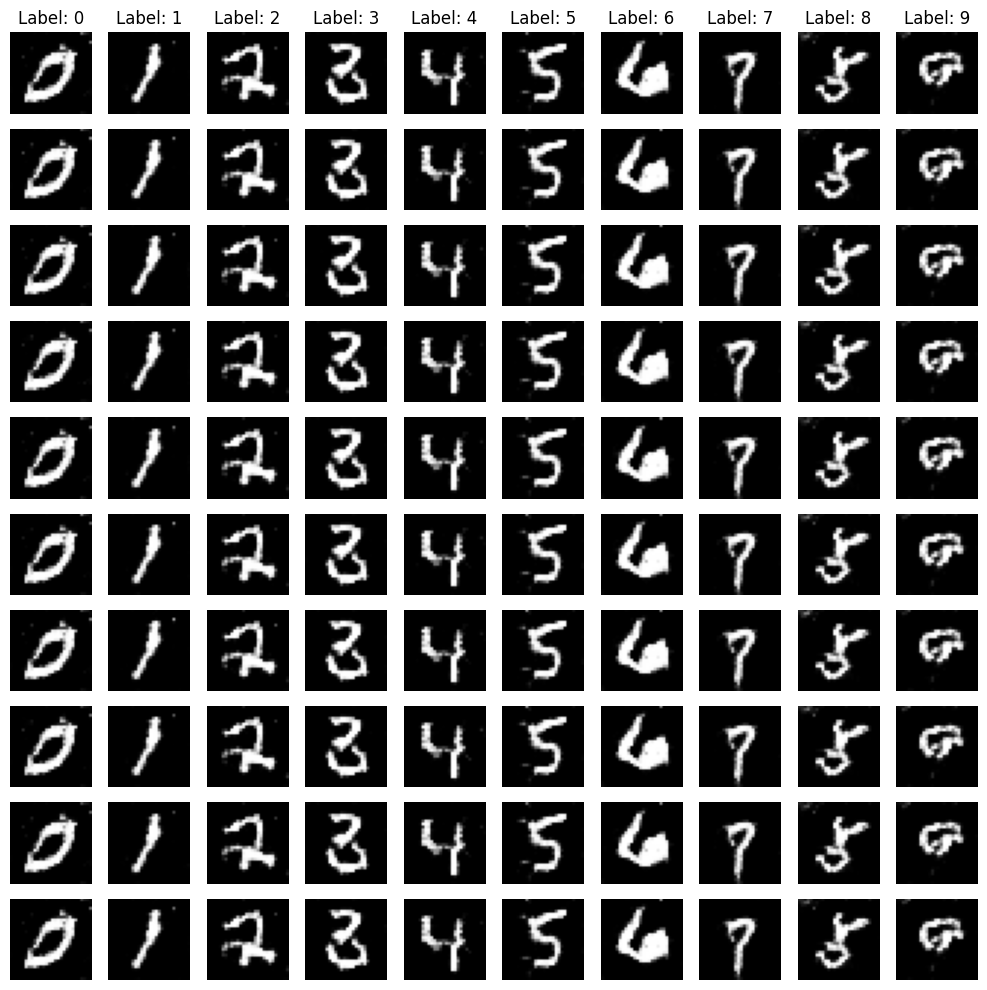

Epoch [71/500] D Loss: 0.7338, G Loss: 1.9294
Epoch [72/500] D Loss: 0.6837, G Loss: 2.0485
Epoch [73/500] D Loss: 0.7191, G Loss: 2.0229
Epoch [74/500] D Loss: 0.6741, G Loss: 2.0668
Epoch [75/500] D Loss: 0.7165, G Loss: 2.0371
Epoch [76/500] D Loss: 0.7143, G Loss: 2.0394
Epoch [77/500] D Loss: 0.6604, G Loss: 2.1333
Epoch [78/500] D Loss: 0.6279, G Loss: 2.0991
Epoch [79/500] D Loss: 0.7300, G Loss: 1.9828
Epoch [80/500] D Loss: 0.6081, G Loss: 2.2518
Generating images at epoch 80...


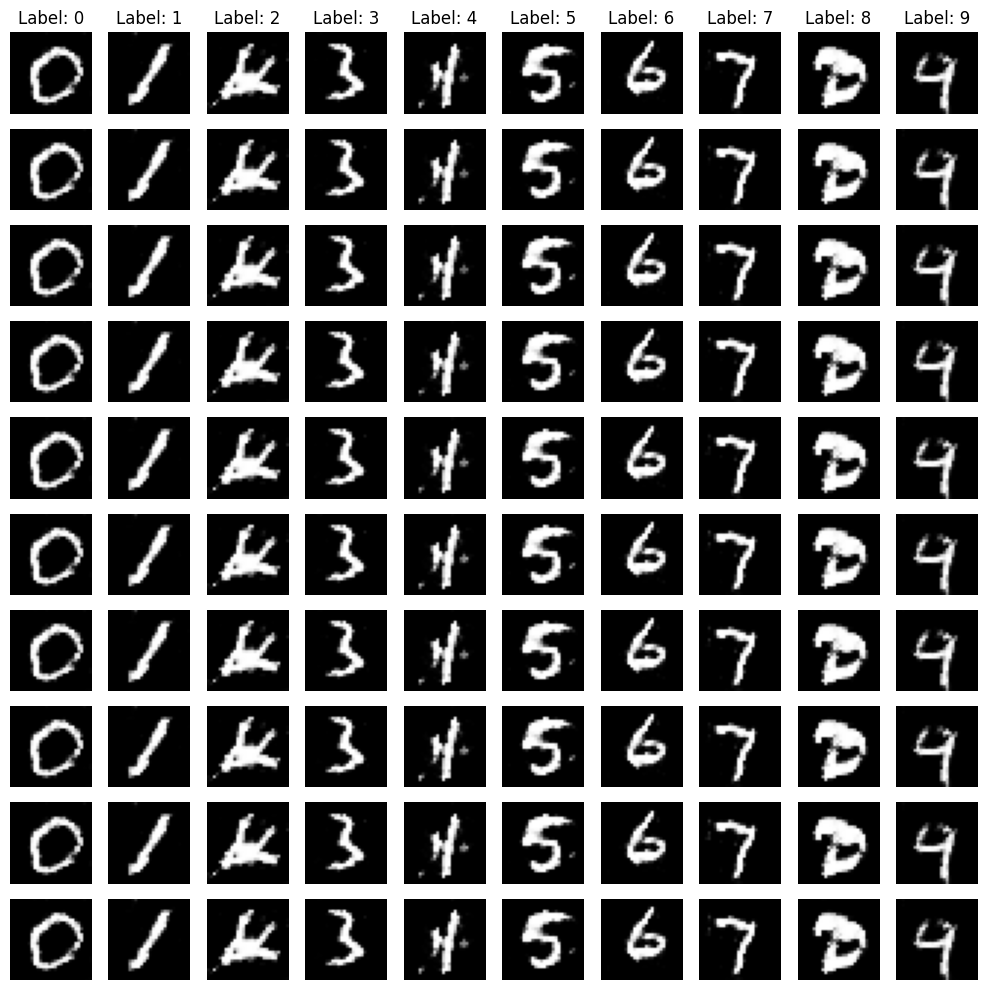

Epoch [81/500] D Loss: 0.6443, G Loss: 2.2159
Epoch [82/500] D Loss: 0.5562, G Loss: 2.3892
Epoch [83/500] D Loss: 0.6534, G Loss: 2.1880
Epoch [84/500] D Loss: 0.6006, G Loss: 2.1944
Epoch [85/500] D Loss: 0.6605, G Loss: 2.1036
Epoch [86/500] D Loss: 0.6170, G Loss: 2.2831
Epoch [87/500] D Loss: 0.6148, G Loss: 2.2543
Epoch [88/500] D Loss: 0.5713, G Loss: 2.3247
Epoch [89/500] D Loss: 0.5510, G Loss: 2.3775
Epoch [90/500] D Loss: 0.7915, G Loss: 1.8642
Generating images at epoch 90...


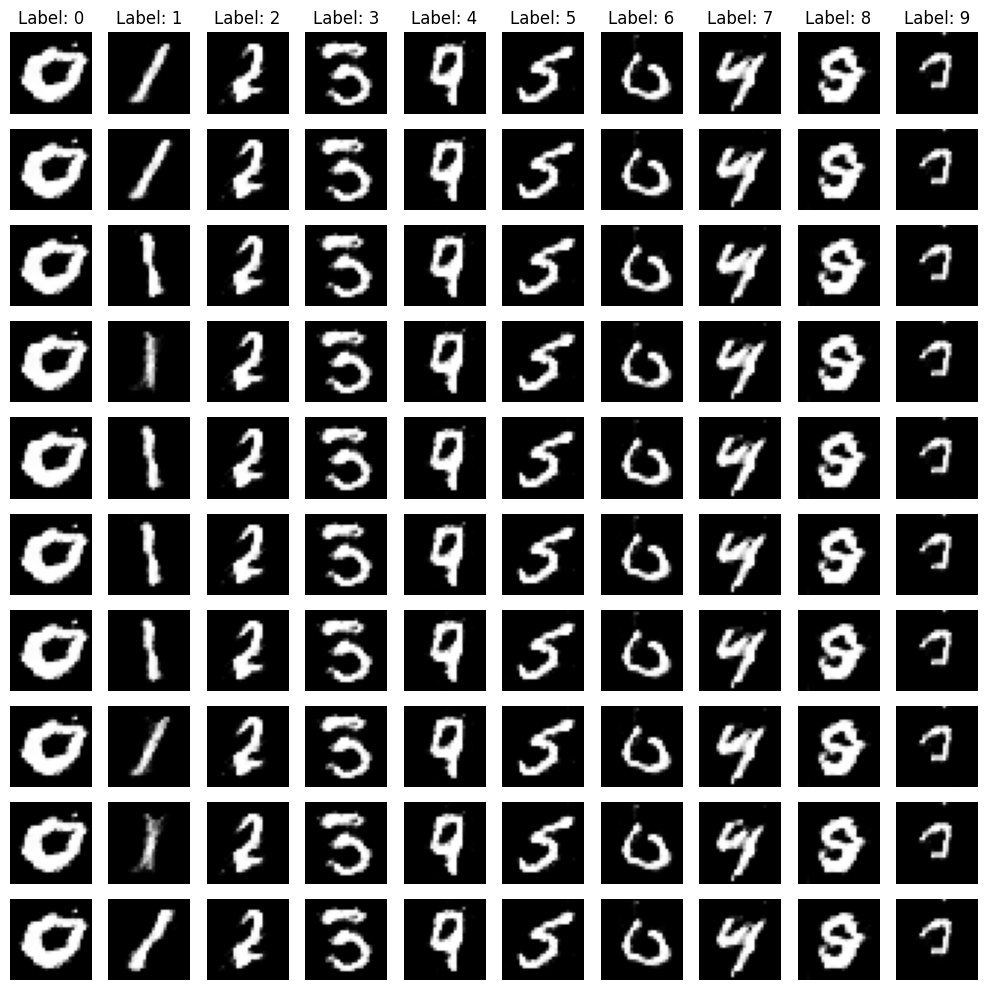

Epoch [91/500] D Loss: 0.7923, G Loss: 1.8194
Epoch [92/500] D Loss: 0.7882, G Loss: 1.9626
Epoch [93/500] D Loss: 0.8097, G Loss: 1.9413
Epoch [94/500] D Loss: 0.7974, G Loss: 1.8330
Epoch [95/500] D Loss: 0.8120, G Loss: 1.8018
Epoch [96/500] D Loss: 0.7842, G Loss: 1.8671
Epoch [97/500] D Loss: 0.8131, G Loss: 1.8059
Epoch [98/500] D Loss: 0.7818, G Loss: 1.8574
Epoch [99/500] D Loss: 0.8297, G Loss: 1.7534
Epoch [100/500] D Loss: 0.7882, G Loss: 1.8458
Generating images at epoch 100...


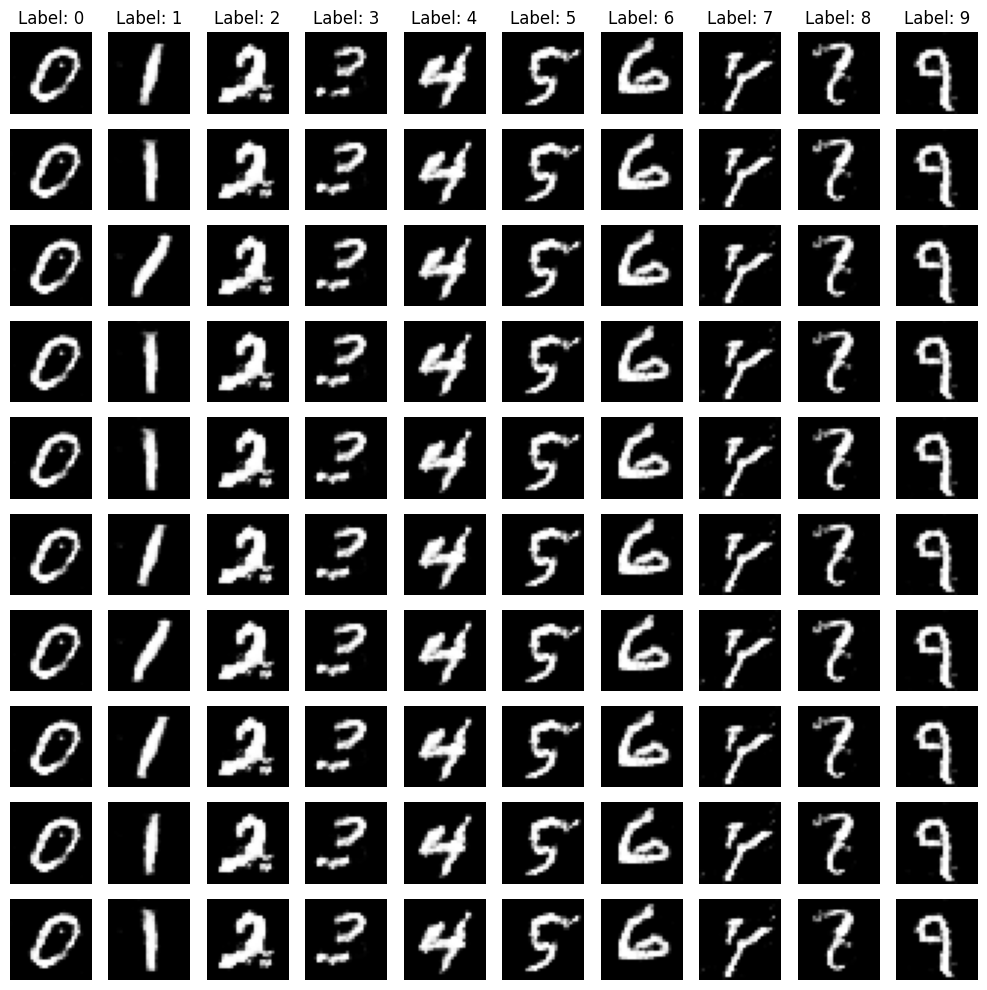

Epoch [101/500] D Loss: 0.8321, G Loss: 1.8940
Epoch [102/500] D Loss: 0.8307, G Loss: 1.7816
Epoch [103/500] D Loss: 0.8187, G Loss: 1.8151
Epoch [104/500] D Loss: 0.7631, G Loss: 1.9248
Epoch [105/500] D Loss: 0.8515, G Loss: 1.7574
Epoch [106/500] D Loss: 0.8074, G Loss: 1.8289
Epoch [107/500] D Loss: 0.8853, G Loss: 1.6724
Epoch [108/500] D Loss: 0.7954, G Loss: 1.7917
Epoch [109/500] D Loss: 0.8144, G Loss: 1.7900
Epoch [110/500] D Loss: 0.8070, G Loss: 1.7849
Epoch [111/500] D Loss: 0.7949, G Loss: 1.8386
Epoch [112/500] D Loss: 0.8042, G Loss: 1.9450
Epoch [113/500] D Loss: 0.7937, G Loss: 1.8230
Epoch [114/500] D Loss: 0.8837, G Loss: 1.7200
Epoch [115/500] D Loss: 0.7543, G Loss: 1.8361
Epoch [116/500] D Loss: 0.7833, G Loss: 1.8183
Epoch [117/500] D Loss: 0.8140, G Loss: 1.8663
Epoch [118/500] D Loss: 0.8761, G Loss: 1.8382
Epoch [119/500] D Loss: 0.7796, G Loss: 1.8441
Epoch [120/500] D Loss: 0.8137, G Loss: 1.8804
Epoch [121/500] D Loss: 0.7766, G Loss: 1.8287
Epoch [122/50

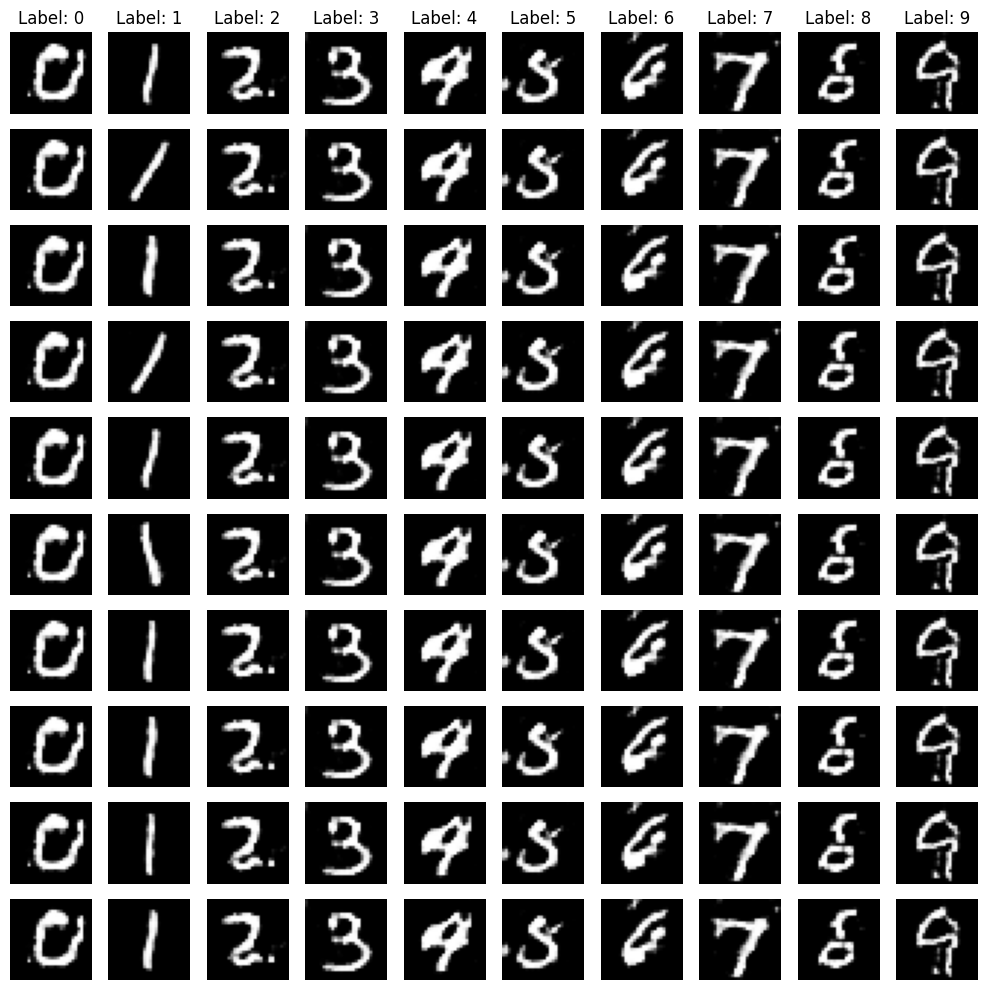

Epoch [201/500] D Loss: 0.6498, G Loss: 2.1260
Epoch [202/500] D Loss: 0.6799, G Loss: 2.0847
Epoch [203/500] D Loss: 0.7548, G Loss: 2.1152
Epoch [204/500] D Loss: 0.7155, G Loss: 2.2051
Epoch [205/500] D Loss: 0.7120, G Loss: 2.0348
Epoch [206/500] D Loss: 0.6912, G Loss: 2.1837
Epoch [207/500] D Loss: 0.6754, G Loss: 2.0888
Epoch [208/500] D Loss: 0.7170, G Loss: 2.0889
Epoch [209/500] D Loss: 0.6395, G Loss: 2.2875
Epoch [210/500] D Loss: 0.7226, G Loss: 1.9629
Epoch [211/500] D Loss: 0.6795, G Loss: 2.1251
Epoch [212/500] D Loss: 0.7706, G Loss: 1.9911
Epoch [213/500] D Loss: 0.6631, G Loss: 2.2101
Epoch [214/500] D Loss: 0.6514, G Loss: 2.2410
Epoch [215/500] D Loss: 0.7088, G Loss: 2.0955
Epoch [216/500] D Loss: 0.6214, G Loss: 2.3168
Epoch [217/500] D Loss: 0.6307, G Loss: 2.3241
Epoch [218/500] D Loss: 0.7110, G Loss: 2.1143
Epoch [219/500] D Loss: 0.6509, G Loss: 2.2908
Epoch [220/500] D Loss: 0.6860, G Loss: 2.1329
Epoch [221/500] D Loss: 0.6796, G Loss: 2.1187
Epoch [222/50

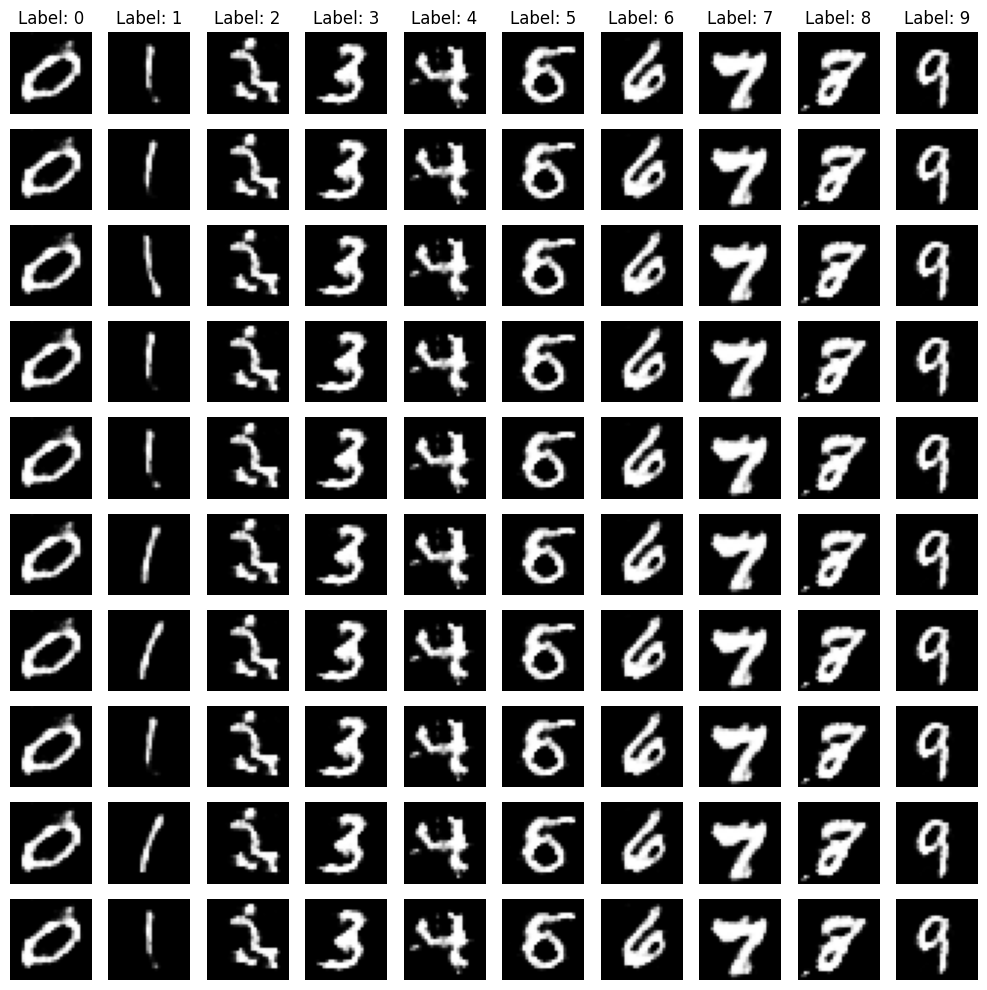

Epoch [301/500] D Loss: 0.6042, G Loss: 2.4104
Epoch [302/500] D Loss: 0.6427, G Loss: 2.2289
Epoch [303/500] D Loss: 0.6322, G Loss: 2.3568
Epoch [304/500] D Loss: 0.5493, G Loss: 2.5318
Epoch [305/500] D Loss: 0.6291, G Loss: 2.3269
Epoch [306/500] D Loss: 0.5980, G Loss: 2.3408
Epoch [307/500] D Loss: 0.5795, G Loss: 2.4163
Epoch [308/500] D Loss: 0.6584, G Loss: 2.2335
Epoch [309/500] D Loss: 0.5515, G Loss: 2.4541
Epoch [310/500] D Loss: 0.5999, G Loss: 2.3786
Epoch [311/500] D Loss: 0.5830, G Loss: 2.3872
Epoch [312/500] D Loss: 0.5618, G Loss: 2.3620
Epoch [313/500] D Loss: 0.5751, G Loss: 2.4192
Epoch [314/500] D Loss: 0.5873, G Loss: 2.3778
Epoch [315/500] D Loss: 0.6151, G Loss: 2.3380
Epoch [316/500] D Loss: 0.5064, G Loss: 2.5938
Epoch [317/500] D Loss: 0.6316, G Loss: 2.2092
Epoch [318/500] D Loss: 0.5496, G Loss: 2.5151
Epoch [319/500] D Loss: 0.5802, G Loss: 2.5094
Epoch [320/500] D Loss: 0.5740, G Loss: 2.3326
Epoch [321/500] D Loss: 0.5863, G Loss: 2.5194
Epoch [322/50

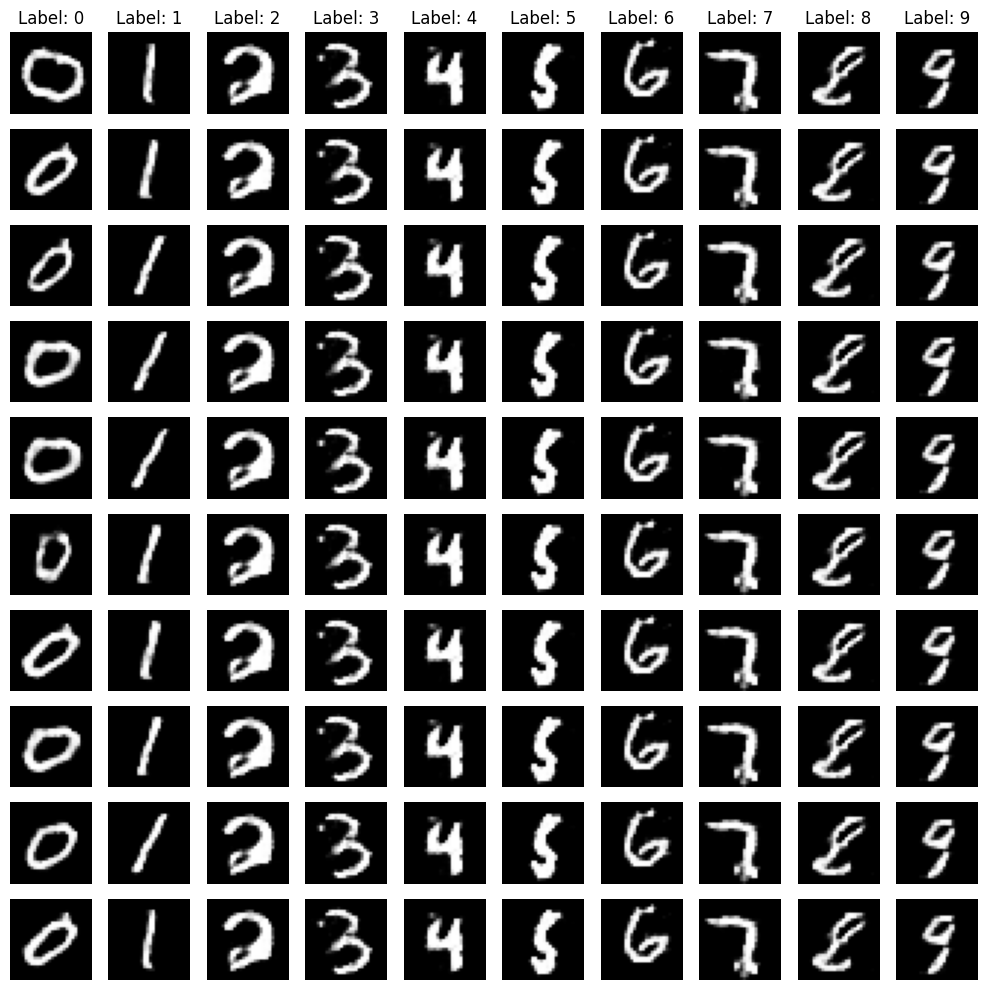

Epoch [401/500] D Loss: 0.5567, G Loss: 2.4116
Epoch [402/500] D Loss: 0.5649, G Loss: 2.5033
Epoch [403/500] D Loss: 0.5804, G Loss: 2.4423
Epoch [404/500] D Loss: 0.5241, G Loss: 2.6709
Epoch [405/500] D Loss: 0.5738, G Loss: 2.5278
Epoch [406/500] D Loss: 0.5188, G Loss: 2.6982
Epoch [407/500] D Loss: 0.5834, G Loss: 2.3600
Epoch [408/500] D Loss: 0.5368, G Loss: 2.5401
Epoch [409/500] D Loss: 0.5228, G Loss: 2.6974
Epoch [410/500] D Loss: 0.5500, G Loss: 2.4941
Epoch [411/500] D Loss: 0.5554, G Loss: 2.4700
Epoch [412/500] D Loss: 0.5262, G Loss: 2.5560
Epoch [413/500] D Loss: 0.4894, G Loss: 2.6172
Epoch [414/500] D Loss: 0.5259, G Loss: 2.5790
Epoch [415/500] D Loss: 0.5450, G Loss: 2.4071
Epoch [416/500] D Loss: 0.5324, G Loss: 2.6328
Epoch [417/500] D Loss: 0.5962, G Loss: 2.4746
Epoch [418/500] D Loss: 0.5358, G Loss: 2.5912
Epoch [419/500] D Loss: 0.5156, G Loss: 2.5559
Epoch [420/500] D Loss: 0.5177, G Loss: 2.6256
Epoch [421/500] D Loss: 0.5172, G Loss: 2.6124
Epoch [422/50

In [9]:
from torchvision import transforms

import matplotlib.pyplot as plt

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


def generate_and_plot(G):
    #生成10*10的图像
    noise = torch.randn(100, 128, device=device)
    # 分别生成0-9的标签
    labels = torch.arange(0, 10, device=device).repeat(10).view(-1, 1)  # (100, 1)
    # 生成图像
    with torch.no_grad():
        generated_images = G(noise, labels)
    generated_images = generated_images.view(100, 28, 28).cpu().numpy()
    # 绘制生成的图像
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')
        if i < 10 :
            ax.set_title(f'Label: {int(labels[i].item())}')
    plt.tight_layout()
    plt.show()
    


def train_gan(G, D, dataloader, epochs, device, output_epochs=[],
              lr_D=2e-4, lr_G=2e-4,
              beta1=0.5,
              noise_dim=128,
              g_train_steps=1,
              ):
    criterion = nn.BCEWithLogitsLoss()  # 二元交叉熵损失

    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, 0.999))
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, 0.999))

    print("开始GAN训练...")
    for epoch in range(epochs):
        D_loss_total = 0
        G_loss_total = 0
        loader_len = len(dataloader)

        # for i, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}/{epochs}", total=loader_len):
        for i, data in enumerate(dataloader):
            real_images, y_label = data
            B = real_images.size(0)
            real_images = real_images.view(-1, 784).to(device)  # 假设28x28图像展平为784
            y_label = y_label.view(B, -1).to(device)

            # --- 训练判别器 (D) ---
            optimizer_D.zero_grad()

            # 使用真实图像进行训练
            real_outputs = D(real_images, y_label)
            # 对真实图像使用软标签，防止D过于自信
            real_labels = torch.full((B,), 0.95, device=device)  # 真实图像的软标签
            errD_real = criterion(real_outputs.view(-1), real_labels.float())
            errD_real.backward()

            # 使用假图像进行训练
            noise = torch.randn(B, noise_dim, device=device)
            # 生成假图像的标签
            fake_image_label = torch.randint(0, 10, (B,), device=device)  # 随机生成标签
            fake_image_label = fake_image_label.view(B, -1)
            fake_images = G(noise, fake_image_label)
            # 在D的训练中，G的输出需要 .detach()，这样G的梯度不会在这里计算
            fake_output = D(fake_images.detach(), fake_image_label)
            # 对D的假图像也使用软标签，但值更低
            fake_labels = torch.full((B,), 0.05, device=device)  # 假图像的软标签
            errD_fake = criterion(fake_output.view(-1), fake_labels)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizer_D.step()
            D_loss_total += errD.item()

            if (i + 1) % g_train_steps == 0:
                # --- 训练生成器 (G) ---
                optimizer_G.zero_grad()
                # 生成新的假图像，避免使用D训练时旧的图像
                noise = torch.randn(B, noise_dim, device=device)
                fake_image_label = torch.randint(0, 10, (B,), device=device)  # 随机生成标签
                fake_image_label = fake_image_label.view(B, -1)
                fake_images = G(noise, fake_image_label)
                # D对G生成的图像的输出。这里至关重要，不要使用 detach()。
                output = D(fake_images, fake_image_label)
                # G希望D将假图像分类为真实（目标标签为1.0或软标签）
                # 这里我们使用完整的1.0作为G的目标，以强烈鼓励它欺骗D
                errG = criterion(output.view(-1), torch.full((B,), 1.0, device=device))
                errG.backward()
                optimizer_G.step()
                G_loss_total += errG.item()

        # --- Epoch 结束总结 ---
        d_loss_avg = D_loss_total / loader_len
        # 根据G的更新次数调整平均损失
        g_loss_avg = G_loss_total / (loader_len // g_train_steps)

        print(f"Epoch [{epoch + 1}/{epochs}] "
              f"D Loss: {d_loss_avg:.4f}, G Loss: {g_loss_avg:.4f}")
        # 如果当前epoch在output_epochs中，则生成图像并保存
        if epoch + 1 in output_epochs:
            print(f"Generating images at epoch {epoch + 1}...")
            generate_and_plot(G)


batch_size = 512
epochs = 500

transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为 Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# 下载 MNIST 数据集
mnist_train = MNIST(root='../../dataset_file/mnist_raw', train=True, download=False, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# 初始化生成器和判别器
G = ConditionalGenerator().to(device)
D = Discriminator().to(device)

# 训练GAN
train_gan(G, D, dataloader, lr_D=1e-4, epochs=epochs, device=device, output_epochs=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400],
          g_train_steps=1)

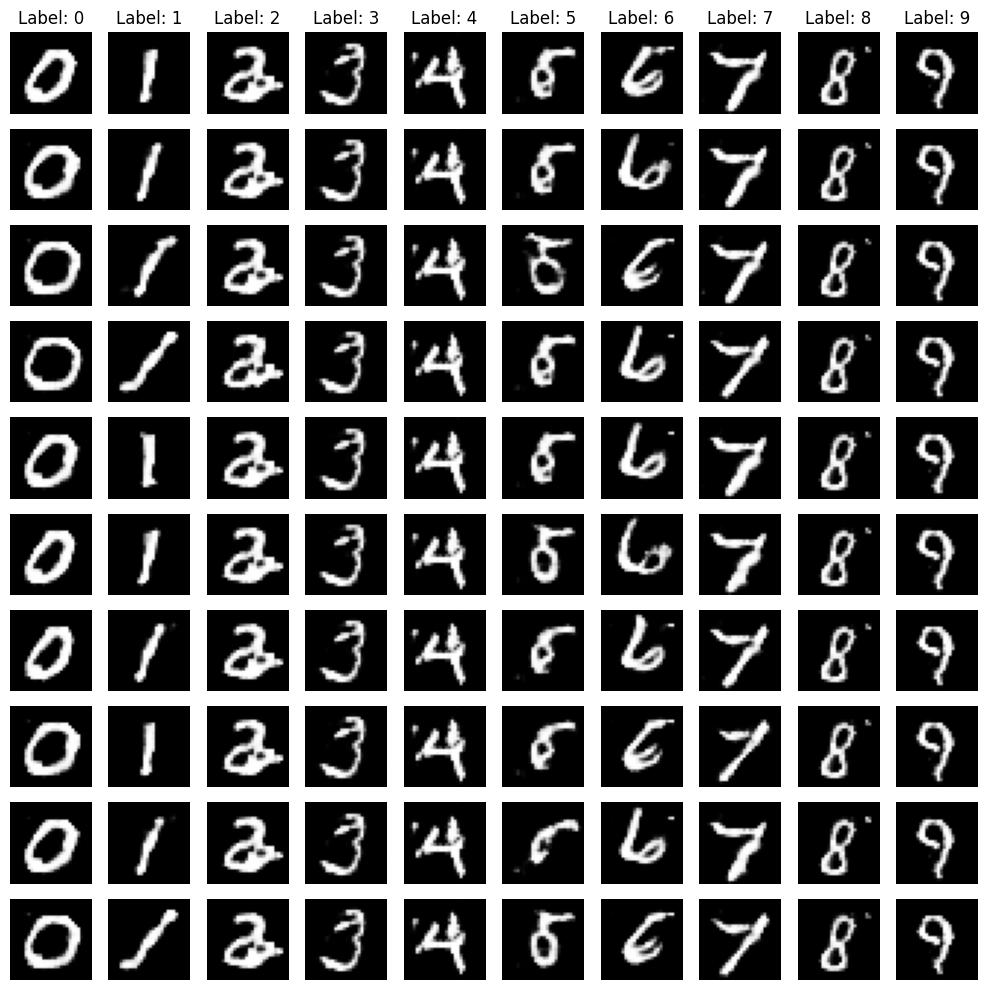

In [13]:
#检测生成质量
generate_and_plot(G)

In [11]:
#保存两个模型
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')